# Universality in Quantum Computers

As you may know, in classical computers using NAND gates alone one can implement all boolean functions. Similarly we can also implement any arbitrary unitary evolution using just CNOT, Hadamard, Phase and $\pi/8$ gates upto an arbitrary level of accuracy. It is important to understand that one cannot represent every unitary evolution since they exist over a continuous set of variables hence could require an infinite number of these gates to execute.

In [18]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit.compiler import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
import qiskit.quantum_info as qi
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-07-30 12:25:33,038: Credentials are already in use. The existing account in the session will be replaced.


## Asymptotic Notation
Before we go any further with explaining universality, let us first get familiarised with the asymptotic notation, which comes in handy while trying to understand the magnitude of speed-up of algorithms.

The $O$ notation is used to set *upper* bounds on the behaviour of a function. Suppose $f(n)$ and $g(n)$ are two functions on non-negative integers. $f(n)$ is said to be $O(g(n))$, if there are constants $c$ and $n_0$ such that for all values of $n > n_0$, $f(n) \leq cg(n)$.

The $\Omega$ notation is used to set *lower* bounds on the behaviour of a function. Suppose $f(n)$ and $g(n)$ are two functions on non-negative integers. $f(n)$ is said to be $\Omega(g(n))$, if there are constants $c$ and $n_0$ such that for all values of $n > n_0$, $cg(n)\leq f(n)$.

Finally, the $\Theta$ notation is used to indicate that $f(n)$ behaves the same as $g(n)$ asymptotically, up to unimportant constant factors. That is, we say $f(n)$ is $\Theta(g(n))$ if it is both $O(g(n))$ and $\Omega(g(n))$.

## Two level unitary operations

A two level unitary matrix is a which affects only two or fewer of the components of the vector it acts on. A $d$ dimensional unitary matrix can be written as a product of at most $d(d-1)/2$ two level unitary matrices. The steps in finding this unitary decomposition is to keep making the diagonal elements of $U$ equal to 1 and make the rest of the row and column zero and at each stage we will get a two level unitary evolution to multiply. repeat till we don't end up with a two level unitary matrix.

A two level unitary acts only on two binary sequences say $|g_1\rangle$ and $|g_m\rangle$ and these are connected by the gray code $|g_2\rangle, |g_3\rangle,\ldots|g_{m-1}\rangle$. A gray code is a sequence where each term differs from the last by just a single bit. Lets say the $|g_{m-1}\rangle$ and $|g_m\rangle$ differ in their $j^{th}$ bit, then we have to construct a controlled operation such that it acts the unitary $\tilde{U}$ on the $j^{th}$ qubit and is controlled by the rest of the cubits. Here $\tilde{U}$ is the sub matrix of $U$ which makes it differ from an identity matrix. However this must be applied after we interchange the $|g_1\rangle$ state with $|g_{m-1}\rangle$

We are now going to try our hand at executing a simple two level unitary given by $U$
$$U = \begin{bmatrix}
      a & 0 & 0 & 0 & 0 & 0 & 0 & c\\
      0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
      0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
      0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
      b & 0 & 0 & 0 & 0 & 0 & 0 & d\\
      \end{bmatrix}$$

We can see that here $\tilde{U} = \begin{bmatrix}a & c\\b & d\end{bmatrix}$ in the cell below. For the sake of this example we will use $R_y(\theta)$ for $\tilde{U}$ and $\theta = \pi/4$ so we write $\tilde{U} = \begin{bmatrix}\cos(\pi/8) & -\sin(\pi/8)\\\sin(\pi/8) & \cos(\pi/8)\end{bmatrix}$

In [19]:
#This cell is just for seeing what the U tilde matrix looks like
a, b, c, d = np.cos(np.pi/8), np.sin(np.pi/8), -np.sin(np.pi/8), np.cos(np.pi/8)
u_tilde = np.array([[a,c],[b,d]]).reshape(2,2)
print(u_tilde)

[[ 0.92387953 -0.38268343]
 [ 0.38268343  0.92387953]]


In [20]:
#This cell defines the controlled variant of the U tilde matrix
qc_for_u = QuantumCircuit(1)
qc_for_u.ry(np.pi/4, 0)
qc_for_u.name = "U"
controlled_u_tilde = qc_for_u.to_gate().control(2)

The two states $U$ affects is $|000\rangle$ and $|111\rangle$. The gray code sequence between them is $|000\rangle\xrightarrow{}|001\rangle\xrightarrow{}|011\rangle\xrightarrow{}|111\rangle$. Here the last two terms differ in their first qubit and we must exchange the state $|000\rangle$ with $|011\rangle$. We can achieve this by using toffolis to sequentially change $|000\rangle$ to $|011\rangle$ and then use a controlled $\tilde{U}$ which is controlled by the second and third qubit and acts on the first qubit. We will now demonstrate this on a circuit.

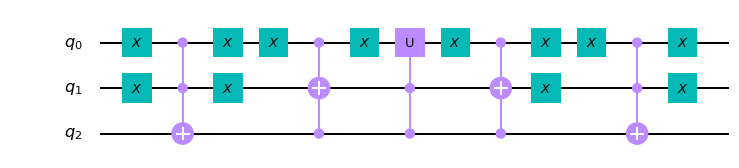

In [21]:
qc1 = QuantumCircuit(3)

qc1.x(0)
qc1.x(1)
qc1.toffoli(0,1,2)#Flipping the third bit if the first two are zero
qc1.x(0)          #Essentially 000 -> 001
qc1.x(1)

qc1.x(0)
qc1.toffoli(0,2,1)#Flipping the second bit if the first bit is zero and the third is one
qc1.x(0)          #Essentially 001 -> 011

qc1.append(controlled_u_tilde, [1, 2, 0])

qc1.x(0)
qc1.toffoli(0,2,1)#Undoing the flip from before
qc1.x(0)

qc1.x(0)
qc1.x(1)
qc1.toffoli(0,1,2)#Undoing the flip from before
qc1.x(0)
qc1.x(1)

qc1.draw('mpl')


Now before you point out that some of these $X$ gates are unnecessary, I have just added them for clarity regarding which toffoli does what.

Now for being sure let's find the unitary of this circuit and compare it with the $U$ which we wished to emulate.

In [22]:
U_circ = qi.Operator(qc1).data
print(U_circ)

[[ 0.92387953+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j -0.38268343+0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.38268343+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   

So it does turn out to be correct! Now here is your task.

## Your task
1) You have to execute the following unitary given by $M$
$$M = \begin{bmatrix}
      a & 0 & 0 & 0 & 0 & 0 & 0 & c\\
      0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
      b & 0 & 0 & 0 & 0 & 0 & 0 & d\\
      0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
      0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
      \end{bmatrix}$$
So first off, this is actually a multiplication of the a two level matrix with the previously defined $U$. We can verify the following.
$$V = \begin{bmatrix}
      1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
      0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
      0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
      0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
      0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
      \end{bmatrix}$$

$$M = V * U$$

So you just have to append the circuit for $V$ to the circuit that is already defined for <code>qc1</code>. You are free to use any apporach as long as you only use $X$ gates and toffolis and the one exception of <code>conntrolled_u_tilde</code>. Also no ancilla bits allowed.

 (**3 points**)

In [23]:
#This cell defines the controlled variant of the U tilde matrix
qc_for_u2 = QuantumCircuit(1)
qc_for_u2.x(0)
qc_for_u2.name = "U2"
controlled_u_tilde2 = qc_for_u2.to_gate().control(2)

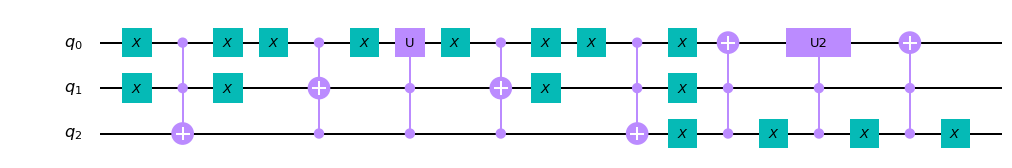

In [25]:
qc2 = QuantumCircuit(3)
#Add code for executing U
qc2.x(0)
qc2.x(1)
qc2.toffoli(0,1,2)#Flipping the third bit if the first two are zero
qc2.x(0)          #Essentially 000 -> 001
qc2.x(1)

qc2.x(0)
qc2.toffoli(0,2,1)#Flipping the second bit if the first bit is zero and the third is one
qc2.x(0)          #Essentially 001 -> 011

qc2.append(controlled_u_tilde, [1, 2, 0])

qc2.x(0)
qc2.toffoli(0,2,1)#Undoing the flip from before
qc2.x(0)

qc2.x(0)
qc2.x(1)
qc2.toffoli(0,1,2)#Undoing the flip from before
qc2.x(0)
qc2.x(1)


#Add code for executing V
qc2.x(2)
qc2.toffoli(1,2,0)
qc2.x(2)
qc2.append(controlled_u_tilde2, [1, 2, 0])
qc2.x(2)
qc2.toffoli(1,2,0)
qc2.x(2)
qc2.draw('mpl')

In [28]:
U_circ = qi.Operator(qc2).data
print(U_circ)

[[ 9.23879533e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.82683432e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.00000000e+00-2.22044605e-16j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  2.77555756e-17+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00-2.22044605e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00

You can verify the correctness of this by running the cell below and seeing if it is accurate. On a sidenote, it is possible that you may have some phase differences in your circuit but in theory they are the same since we ignore global phase so we have the function <code>without_global_phase</code> for removing global phase. (Mostly your circuit wouldnt have a global phase since you are going to use only  $X$ and toffoli and even $R_y$ doesnt have phase).

In [27]:
def without_global_phase(matrix: np.ndarray, atol: float = 1e-8) :
    phases1 = np.angle(matrix[abs(matrix) > atol].ravel(order='F'))
    if len(phases1) > 0:
        matrix = np.exp(-1j * phases1[0]) * matrix
    return matrix
V_circ = without_global_phase(qi.Operator(qc2).data)
print(V_circ)

[[ 9.23879533e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.82683432e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.00000000e+00-2.22044605e-16j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  2.77555756e-17+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00-2.22044605e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00

For a two level unitary evolution we can see that it takes complexity of $O(n^2)$ on breaking down into CNOTs and single qubit gates. If we were to extend this to an arbitrary unitary evolution we can see that it will become $O(n^{2}2^{2n})$ since an arbitrary unitary evolution can be represented as a product of $O((2^n)^2)$ since the operator is $2^n$ dimensional and the number of two level matrices required is in $n^2$ complexity.

## Approximating single qubit unitary gates

Now here's the thing. Notice how we so freely used any arbitrary single qubit gate? Well we often just cannot come up with any arbitrary unitary operation over a single qubit so easily.

We will now define a quantity $E(U,V)$ where $U$ and $V$ are unitary operators of the same state space.
$$E(U,V) = max||(U - V)|\psi\rangle||$$

The max represents the maximum over all possible $|\psi\rangle$ in the state space. Suppose a quantum system starts in the state $|\psi\rangle$, and we perform either the unitary operation $U$, or the unitary operation $V$ . Following this, we perform a measurement. Let $M$ be a POVM element associated with the measurement, and let $P_U$ (or $P_V$) be the probability of obtaining the corresponding measurement outcome if the operation $U$ (or $V$) was performed. We then have
$$|P_U - P_V| = |\langle\psi|U^{\dagger}MU|\psi\rangle - \langle\psi|V^{\dagger}MV|\psi\rangle|$$
If we substitute $|\Delta\rangle = (U - V)|\psi\rangle$ we get the following from Cauchy-Schwarz inequality
$$|P_U - P_V| = |\langle\psi|U^{\dagger}M|\Delta\rangle + \langle\Delta|MV|\psi\rangle|$$
$$|P_U - P_V| \leq |||\Delta\rangle|| + |||\Delta\rangle||$$
$$|P_U - P_V| \leq 2E(U,V)$$

Hence if $E(U,V)$ is small, the measurement results of $U$ and $V$ will also be very close. Note that if we use sequenced gates, the error value will add up linearly and so wouldn't actually cause big problems
$$E(U_{2}U_{1} - V_{2}V_{1}) = ||(U_{2}U_{1} - V_{2}V_{1})|\psi\rangle||$$
$$E(U_{2}U_{1} - V_{2}V_{1}) = ||(U_{2}U_{1} - V_{2}U_{1})|\psi\rangle + (V_{2}U_{1} - V_{2}V_{1})|\psi\rangle||$$
$$E(U_{2}U_{1} - V_{2}V_{1}) = ||(U_{2}U_{1} - V_{2}U_{1})|\psi\rangle + (V_{2}U_{1} - V_{2}V_{1})|\psi\rangle||$$
Using triangle inequality we get
$$E(U_{2}U_{1} - V_{2}V_{1}) \leq ||(U_{2} - V_{2})U_{1}|\psi\rangle|| + ||U_{1} - V_{1})V_{2}|\psi\rangle||$$
$$E(U_{2}U_{1} - V_{2}V_{1}) \leq E(U_2,V_2) + E(U_1,V_1)$$
This can be extended to any number of operations using induction.

Consider the operations $T$ and $HTH$. $T$ gives a rotation about $Z$ axis by an angle of $\pi/4$. $HTH$ gives a rotation about $X$ axis by an angle of $\pi/4$. Combining these both we get

$$
\exp(-\iota\dfrac{\pi}{8}Z)\exp(-\iota\dfrac{\pi}{8}X) = \Big[\cos\left(\dfrac{\pi}{8}\right)I - {\iota}\sin\left(\dfrac{\pi}{8}\right)Z\Big]\Big[\cos\left(\dfrac{\pi}{8}\right)I - {\iota}\sin\left(\dfrac{\pi}{8}\right)X\Big]
$$

$$
\exp(-\iota\dfrac{\pi}{8}Z)\exp(-\iota\dfrac{\pi}{8}X) = {\cos}^2\left(\dfrac{\pi}{8}\right)I - \iota\Big[\cos\left(\dfrac{\pi}{8}\right)(X + Z) + \sin\left(\dfrac{\pi}{8}\right)Y\Big]\sin\left(\dfrac{\pi}{8}\right)
$$

As one can see this obtains us a rotation by an $\theta$  such that $\cos\left(\dfrac{\theta}{2}\right) = {\cos}^2\left(\dfrac{\pi}{8}\right)$ about the vector $\vec{n} = \left(\cos\dfrac{\pi}{8},\sin\dfrac{\pi}{8},\cos\dfrac{\pi}{8}\right)$. We can see that this $\theta$ is an irrational multiple of $2\pi$. Hence suppose we wish to make $R_{\vec{n}}(\alpha)$ for some arbitrary $\alpha$ we can replicate to an arbitrary accuracy using repeated iteration $R_{\vec{n}}(\theta)$

Lets say we wish to have it to some accuracy $\delta$ and $N$ is an integer larger than $2\pi/\delta$. Lets define a sequence $\theta_k = (k\theta)$mod $2\pi$. From pigeonhole principle we can see that there exists distinct $j,k \in{1,2,.....N}$ such that $|\theta_j - \theta_k| \leq 2\pi/N < \delta$ hence we can use $\theta_{l(j-k)}$ to attain any value in $[0, 2\pi)$ with accuracy of $\delta$.

Now we can see that $HR_{\vec{n}}(\theta)H = R_{\vec{m}}(\theta)$ where $\vec{m} = \left(\cos\dfrac{\pi}{8},-\sin\dfrac{\pi}{8},\cos\dfrac{\pi}{8}\right)$. Now if we recall eq. 3.2, we can see that all unitary operators can be represented as the following subject to a certain level of accuracy.

$$
U = e^{i\alpha}{R_{\vec{n}}(\theta)}^{n_1}H{R_{\vec{n}}(\theta)}^{n_2}H{R_{\vec{n}}(\theta)}^{n_3}
$$

Now here is the important question. How efficient is this approach? Say we have $m$ gate circuit we wish to replicate to closeness of $\epsilon$ (we define this closeness as $E(U,V) < \epsilon$). This will give us a $\Omega(m2^{(m/\epsilon)})$ which is not really good however with the $\theta_k$ approach we can see that the range of angles gets filled up fairly uniformly so we can consider a complexity of some $\Theta(m^2/\epsilon)$. This gives us a fairly good approach however it can get even better. According to the Solovay-Kitaev theorem one can achieve a complexity of $O(mlog(m/\epsilon))$

TL;DR we can create any single qubit unitary just using some good old $T$ and $H$ gates or anything which can help us find a rotation which of any irrational angle. Now we will just explore some simple examples for that but first we will define a function for finding the norm difference between two unitaries barring the global phase so we can check validation.

In [29]:
#Function just returns norm ignoring global phase between unitaries
def norm(unitary_a: np.ndarray, unitary_b: np.ndarray) :
    return np.linalg.norm(without_global_phase(unitary_b)-without_global_phase(unitary_a), ord=2)

## Your task
2) While one can try to break their head around making very complex unitaries using this approach, we are going to give some relatively simpler ones which should be possible to do with not a very large number of $T$ and $H$ gates.  (**2 points**)

In [ ]:
#Make the Pauli Y gate
qcy = QuantumCircuit(1)
#
#
#Your code here
#
#
Y_circ = qi.Operator(qcy).data
Y = np.array([[0,-1j],[1j,0]])
print(norm(Y_circ,Y))

## Bonus question (not compulsory but encouraged)

This next task is for a unitary that you are given and is stored in <code>uni_q</code>. You have to make this unitary purely using $H$ and $T$ gates. 

So firstly here are some hints, this unitary will require no more or less than 5 $H$ gates and that is all you know. The rest of the required gates are obviously $T$. An obvious approach is to try multiple combinations till the norm difference reaches a very small amount and for that at every trial you can use the good old <code>qi.Operator(circuit).data</code> to get the unitary of the circuit at that moment. If you want to re initiallize your circuit i.e. clear out all the gates, then simply do <code>qc3 = QuantumCircuit(1)</code> again.

Another note: $T^8 = I$ and also the hint doesn't really describe an optimal approach so it might take some time to execute but it is possible to approach the answer quicker using some randomness but of course that would depend on the initialized seed.

 (**6 points**)

In [ ]:
uni_q = np.array([[-0.25+0.60355339j, 0.60355339+0.45710678j],
                   [0.60355339-0.45710678j, 0.25+0.60355339j]]).reshape(2,2)

qc3 = QuantumCircuit(1)
#
#
#Your code here
#
#
uni_q_circ = qi.Operator(qc3).data
print(norm(uni_q_circ,uni_q))

You would mostly be getting extremely small errors (mostly much smaller than 1e-8). The reason we are getting extremely small errors is mostly because the <code>qi.Operator(circuit).data</code> makes certain floating point errors but these are clearly insignificant.

## Bonus question (not compulsory but encouraged)

The following gate is also a universal gate by itself (of course you will require ancilla bits but it can do the job).
<img src="https://raw.githubusercontent.com/mnp-club/Quantum_Computing_Workshop_2020/master/images/universal_irx.png"></img>
Here $\alpha$ is an irrational number. For the sake of this example we will take $\pi\alpha = \cos^{-1}(3/5)$ and it is trivial to prove that this would give us an irrational $\alpha$. Now your task is to somehow get a $|+\rangle$ state on a qubit using this and you may use as many qubits and these gates as you want. Since it is rather trivial that we can execute $X$ gates and CNOTs using this gate, you are also allowed to use them.

Hints: imagine you start from a two-qubit state $|00\rangle$, and apply a $R_x(\pi/2)$ to the first qubit. Then apply a controlled-not controlled off the first qubit and targeting the second qubit. Next, apply the inverse of the first rotation. Finally, measure the first qubit. If you get answer $|1\rangle$, the second qubit is in the $|-\rangle$ state and if you get the result $|0\rangle$, the second qubit will be in state $|+\rangle$.

You are of course free to just ignore the hint and do whatsoever you wish to as long as you reach $|+\rangle$

In [ ]:
#Defining the gate as controlled_irx
from qiskit.extensions import *
pi_alpha = np.arccos(0.6)
qc_for_irx = QuantumCircuit(1)
irx = np.array([[1j*np.cos(pi_alpha/2),np.sin(pi_alpha/2)],[np.sin(pi_alpha/2),1j*np.cos(pi_alpha/2)]]).reshape(2,2)
g_irx = UnitaryGate(data=irx,label=None)
controlled_irx = g_irx.control(2)

In [ ]:
n = 4
qcb = QuantumCircuit(n,n)
qcb.x(0)#Ancilla
qcb.x(1)#Ancilla  You can use these two as control to use the controlled_irx gate
#
#
#
#
#Your code here
#
#
#
#
#Get state of qubit which should have the |+> state using the backend simulator
i = None#Index for the qubit at |+> state
qcb.h(i)#Puts the |+> state to |0>
qcb.measure(i, i)
def run_circuit(qcb):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qcb, backend, shots = 2000).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

counts = run_circuit(qcb)
print(counts)
plot_histogram(counts)

If your answer is correct then you should see nearly all shots on $|0000\rangle$ because you have only chosen the ith qubit for measurement so it will just assign a default zero to the rest. 
Should you choose to measure all the qubits, you may see a different answer depending on your approach. If you follow the hints approach you will get an equal distribution between $|0011\rangle$ and $|0111\rangle$